In [1]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle

import helpers as helper

#### Metadata from raw data file

In [2]:
# load data
with open('../../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)

# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID', 'shape': 'dims'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

# keep only test set
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)

# collect metadata
metadata = test[['ID', 'waferMap', 'dieSize', 'lotName', 'dims', 'failureType', 'detectLabels', 'classifyLabels']]
print(metadata.shape)
metadata.head()

(25943, 8)


,ID,waferMap,dieSize,lotName,dims,failureType,detectLabels,classifyLabels
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8


#### Explore mislabeled

In [3]:
cls_metadata = metadata[metadata.classifyLabels != 8].reset_index(drop=True)
len(cls_metadata)

3828

In [4]:
with open('../results/yuclassify-paper.pkl', "rb") as fh:
    cls_paper = pickle.load(fh)
len(cls_paper[0])

3828

In [5]:
# LISTS

# make list of IDs of misclassified wafers
cls_miss = [cls_metadata.ID[i] for i in range(3828) if cls_paper[0][i] != cls_metadata.classifyLabels[i]]
print(f'Misclassified wafers: {len(cls_miss)}')

# make list of probabilities for prediction
cls_probs = [x[i]*100 for x, i in zip(cls_paper[1], cls_paper[0])]

# make list of second highest prediction
cls_pred2 = [x.argsort()[-2] for x in cls_paper[1]]
len(cls_pred2)

# make list of second highest probabilties for prediction
cls_probs2 = [x[i]*100 for x, i in zip(cls_paper[1], cls_pred2)]
len(cls_probs2)

# make list of model probability for true label
cls_labelprob = [x[i]*100 for x, i in zip(cls_paper[1], cls_metadata.classifyLabels)]
len(cls_labelprob)

Misclassified wafers: 239


3828

In [6]:
# collect in one dataframe
cls_analysis = cls_metadata.copy()
cls_analysis['cls_pred'] = cls_paper[0].tolist()
cls_analysis['cls_prob'] = cls_probs
cls_analysis['cls_pred2'] = cls_pred2
cls_analysis['cls_prob2'] = cls_probs2
cls_analysis['cls_labelprob'] = cls_labelprob
cls_analysis.head()

,ID,waferMap,dieSize,lotName,dims,failureType,detectLabels,classifyLabels,cls_pred,cls_prob,cls_pred2,cls_prob2,cls_labelprob
0,42,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,"(53, 58)",Edge-Loc,1,1,1,99.455875,3,0.424250,99.455875
1,97,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot5,"(53, 58)",Edge-Ring,1,3,3,85.699672,1,14.271392,85.699672
2,130,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot6,"(53, 58)",Scratch,1,4,4,99.951160,0,0.043069,99.951160
3,173,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot8,"(26, 26)",Edge-Ring,1,3,3,96.809888,1,3.184079,96.809888
4,346,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...",533.0,lot16,"(26, 26)",Edge-Loc,1,1,1,91.011143,0,8.839290,91.011143


In [7]:
# keep only subset of mislabeled wafers
miss_indices = [cls_analysis.index[cls_analysis.ID == i][0] for i in cls_miss]
cls_misclassified = cls_analysis.loc[miss_indices].reset_index(drop=True)
len(cls_misclassified)

239

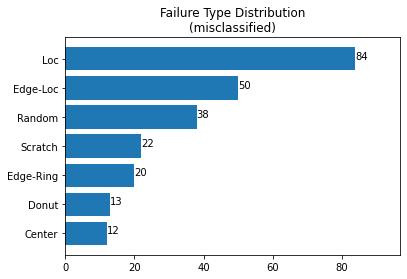

In [8]:
# distribution of defects in misclassified
helper.defect_distribution(cls_misclassified, mode='classify', note='misclassified')

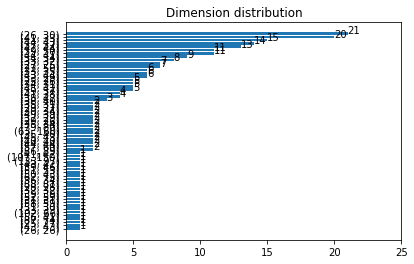

In [9]:
# distribution of dims
dist = cls_misclassified.groupby('dims')['dims'].count().sort_values()
y = dist.tolist()
x = [str(dim) for dim in cls_misclassified.dims.unique()]

plt.barh(x, y)
xlim = math.ceil(max(y)*1.15)
plt.xlim(0, xlim)
plt.title("Dimension distribution")

for index, value in enumerate(y):
    plt.text(value, index,
             str(value))

plt.show()

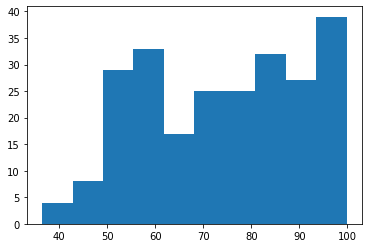

In [14]:
plt.hist(cls_misclassified.cls_prob)
pass

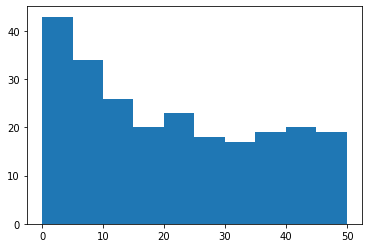

In [10]:
plt.hist(cls_misclassified.cls_labelprob)
pass

In [12]:
second_right = [cls_misclassified.ID[i] for i in range(239) if cls_misclassified.cls_pred2[i] == cls_metadata.classifyLabels[i]]
len(second_right)

33